In [1]:
### Libraries necessary to run this IPython Notebook

!pip install folium
!pip install geocoder
!pip install tqdm

    100% |████████████████████████████████| 71kB 170kB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 154kB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 120kB/s a 0:00:011


#### Load libraries and set options

In [2]:
# Load relevant libraries
import pandas as pd
import numpy as np
import matplotlib
import folium
import geocoder
from tqdm import tqdm
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)

Populating the interactive namespace from numpy and matplotlib


## 1. Introduction to Geocoding
Geocoding is the process of transforming a description of a location to a spatial location on the surface of the earth. 

### 1.1 Geocoder
There are several geocoding libraries and services available. In this notebook will demonstrate the use of the [Geocoder](https://pypi.python.org/pypi/geocoder/) Python library, using [Google Maps](https://maps.google.com) as provider.

We start by geocoding a single city and country combination. You can change the values of the city if you wish.

In [3]:
# Let's geocode a city in the format of the data set that we have available
g = geocoder.google('Currais Novos, Brazil')

# Print the lattitude and longitude for the city
g.latlng

[-6.255135399999999, -36.5143974]

You can use the same library to find the location based on IP addresses. When executing this on your virtual analysis environment, the location of the server will be returned.

In [4]:
# Find your location based on your IP address
mylocation = geocoder.ip('me')

# print your location
mylocation.latlng

[-5.7917, -35.2]

### 1.2 Input data: Student location

We have extracted an earlier snapshot of the current student group, allocated a new id and included industry, country and city. The intention here is to show you what can be achieved with minimal input. 

#### 1.2.1 Load the data

In [5]:
# Load student location data and display the header
df = pd.read_csv('students_raw.csv')
df.head(10)

id          industry        country         city
0  10001       Agriculture  United States        Davis
1  10002  Arts & Education      Australia        Perth
2  10003  Arts & Education        Austria      Lieboch
3  10004  Arts & Education         Brazil    São Paulo
4  10005  Arts & Education         Canada   Georgetown
5  10006  Arts & Education         Canada     Hamilton
6  10007  Arts & Education         Canada       Milton
7  10008  Arts & Education         Canada  Mississauga
8  10009  Arts & Education         Canada       Regina
9  10010  Arts & Education         Canada      Toronto

Consider the forms and applications that you complete regularly. You may be happy to share your personal information with the company providing you with a product or service, but you will likely not be happy if they start sharing the information publicly. Many people provide this data in social media on public forums and do not necessarily think about the potential consequences. 

One of the techniques to hide sensitive data is to only release aggregated data. The biggest problem with this approach is that you are still able to identify persons in low density areas of the data set. You need to be extremely careful when designing applications that utilize personal data to ensure that you do not breach the trust of the users who supplied you with their data.

We have removed names, surnames, telephone numbers, and email addresses, but many of you would still be able to provide an accurate guess about the random id allocated to you in dataset, df in 1.2.1, based on the examples below.


#### 1.2.2 Prepare the data

In [6]:
# Step 1: Group the data to hide the user id
df1 = pd.DataFrame(df.groupby(['country', 'city', 'industry'])['id'].count()).reset_index()
df1 = df1.rename(columns = {'id':'student_count'})
df1.head(10)

country           city          industry  student_count
0  Australia       Adelaide  Other or Unknown              1
1  Australia         Bronte  Other or Unknown              1
2  Australia        Buddina               ICT              1
3  Australia    Carlingford               ICT              1
4  Australia  Glen Waverley               ICT              1
5  Australia     Haberfield               ICT              1
6  Australia     Kellyville  Other or Unknown              1
7  Australia    Kogarah Bay  Other or Unknown              1
8  Australia         Logan   Other or Unknown              1
9  Australia          Manly  Other or Unknown              1

#### 1.2.3 Retrieve data for a specific city

In [7]:
# Return all rows for New York
df1.loc[df1['country'] == 'Brazil']

country            city             industry  student_count
29  Brazil        Brasilia        Public Sector              1
30  Brazil    Juiz De Fora               Health              1
31  Brazil           Natal          Engineering              1
32  Brazil         Niteroi    Media & Marketing              1
33  Brazil  Rio De Janeiro                  ICT              1
34  Brazil  Rio De Janeiro    Media & Marketing              2
35  Brazil  Rio De Janeiro     Other or Unknown              1
36  Brazil       Sao Paulo  Finance & Insurance              2
37  Brazil       Sao Paulo                  ICT              2
38  Brazil       Sao Paulo               Mining              1
39  Brazil       Sao Paulo     Other or Unknown              5
40  Brazil       Sâo Paulo     Other or Unknown              1
41  Brazil       São Paulo     Arts & Education              1
42  Brazil       São Paulo    Media & Marketing              2
43  Brazil       São Paulo          Real Estate              2

#### 1.2.4 Plot students per country

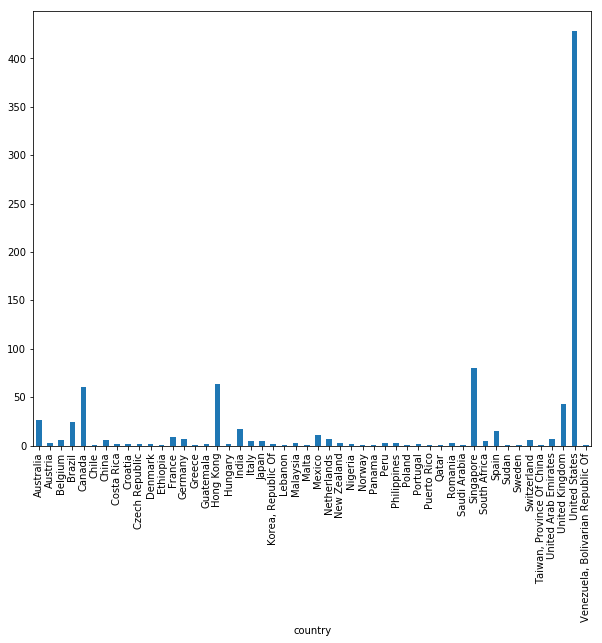

In [8]:
# Plot the count of students per country
country_counts = df1.groupby(['country'])['student_count'].sum()
country_counts.plot(kind='bar')


#### 1.2.5 Plot students per industry

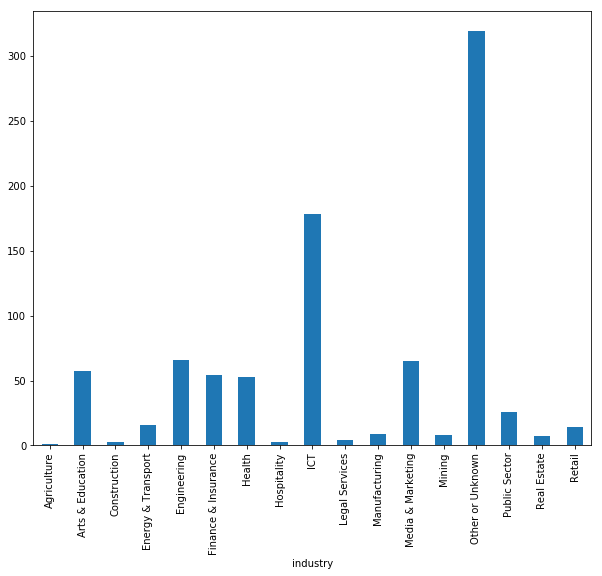

In [9]:
# Plot the count of students per industry
industry_counts = df1.groupby(['industry'])['student_count'].sum()
industry_counts.plot(kind='bar')

#### 1.2.7 Prepare the dataframe for geocoding

In [10]:
# We tested the geocoder library with town and country as input. Let's create a new column in our dataframe that contains these values.
df1['geocode_input'] = df1['city'] + ', ' + df1['country']

# We also create two additional columns for lattitude and longitude.
df1['lat'], df1['long'] = [0, 0]

# Display the head of the updated dataframe.
df1.head()

country           city          industry  student_count  \
0  Australia       Adelaide  Other or Unknown              1   
1  Australia         Bronte  Other or Unknown              1   
2  Australia        Buddina               ICT              1   
3  Australia    Carlingford               ICT              1   
4  Australia  Glen Waverley               ICT              1   

              geocode_input  lat  long  
0       Adelaide, Australia    0     0  
1         Bronte, Australia    0     0  
2        Buddina, Australia    0     0  
3    Carlingford, Australia    0     0  
4  Glen Waverley, Australia    0     0

### 1.3 Geocoding the data

Next, you will geocode cities in the student registrations list in order to display the locations on a map.

This cell will run through a loop and geocode each of the city and country combinations provided as input. This process may take up to 5 minutes. The response is influenced by the target server capacity.

We can use this opportunity to demonstrate how you can save intermediary results as an output file, which you can load when resuming your analysis at a later stage without having to redo all the processing.


In [11]:
# Now we use Geocoder in a loop to gecode the cities and update our dataframe
# Wait until the In{*} indicator on the lefthand side changes to a number before proceeding

for i in tqdm(range(len(df1))):
    g = geocoder.google(df1.loc[i,'geocode_input'])
    df1.ix[i,'lat'] = g.lat
    df1.ix[i,'long'] = g.lng
print('Geocoding complete!')

 77%|███████▋  | 531/690 [09:21<02:32,  1.04it/s]

KeyboardInterrupt: 

In [ ]:
# Let's look at the dataframe again to see the populated values for latitude and longitude.
df1.head()

### 1.4 Saving and retrieving your resultset to CSV
In some cases you would want to save result sets. You can utilise this technique to store copies of intermediary results where you do not wish to perform the calculations again when resuming your analysis or to output the result to be shared or utilized in other applications. 

In [ ]:
# To save the output to a file you can use the command below and replace "filename_export" with a name of your choice.
df1.to_csv('students_export.csv')

In [ ]:
# To load the file you just generated, you can replace the filename below with the one you entered in the previous cell.
# Create a new Pandas dataframe with the file created in the previous cell.
new_df = pd.read_csv('students_export.csv')

### 1.5 Plotting the geocoded data on a map

You can visit the Folium [documentation](http://folium.readthedocs.io/en/latest/) or browse the [GitHub](https://github.com/python-visualization/folium) repository for further instructions and examples.

Feel free to change the map and try to visualize the count of students per country or the count of students per industry per country.

In [ ]:
# Set map center and zoom level
mapc = [0, 30]
zoom = 2

# Create map object
map_osm = folium.Map(location=mapc,
                    zoom_start=zoom)
# Plot each of the locations that we geocoded
for j in tqdm(range(len(df1))):
    folium.Marker([df1.ix[j,'lat'], df1.ix[j,'long']],
        icon=folium.Icon(color='green',icon='info-sign')
        ).add_to(map_osm)
# Show the map
map_osm

In [ ]:
from folium.plugins import HeatMap

# Set map center and zoom level
mapc = [0, 30]
zoom = 2

coordinates = []

for i in range(len(df1)):
    # eliminate items with'nan' element
    if all(~np.isnan([df1.ix[i,'lat'], df1.ix[i,'long'], df1.ix[i,'student_count']])):
        coordinates.append([df1.ix[i,'lat'], df1.ix[i,'long'], df1.ix[i,'student_count']])

# Create map object
m = folium.Map(location=mapc,
                    zoom_start=zoom)

HeatMap(coordinates).add_to(m)

m
